In [30]:
import numpy as np
from skimage import io
from skimage import data
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, ORB, plot_matches, BRIEF
from skimage.measure import ransac
from skimage.transform import FundamentalMatrixTransform
import matplotlib.pyplot as plt

np.random.seed(0)

arma_file="./data/arma.jpg"
kit1_file="./data/kit1.jpg"
img_left = io.imread(arma_file)
img_right= io.imread(kit1_file)

img_left, img_right = map(rgb2gray, (img_left, img_right))



In [31]:
# Find sparse feature correspondences between left and right image.

descriptor_extractor = ORB(n_keypoints=200)

descriptor_extractor.detect_and_extract(img_left)
keypoints_left = descriptor_extractor.keypoints
descriptors_left = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img_right)
keypoints_right = descriptor_extractor.keypoints
descriptors_right = descriptor_extractor.descriptors

matches = match_descriptors(descriptors_left, descriptors_right,
                            cross_check=True)



In [32]:
# Estimate the epipolar geometry between the left and right image.

model, inliers = ransac((keypoints_left[matches[:, 0]],
                         keypoints_right[matches[:, 1]]),
                        FundamentalMatrixTransform, min_samples=8,
                        residual_threshold=1, max_trials=5000)

inlier_keypoints_left = keypoints_left[matches[inliers, 0]]
inlier_keypoints_right = keypoints_right[matches[inliers, 1]]

print(f"Number of matches: {matches.shape[0]}")
print(f"Number of inliers: {inliers.sum()}")



Number of matches: 24
Number of inliers: 16


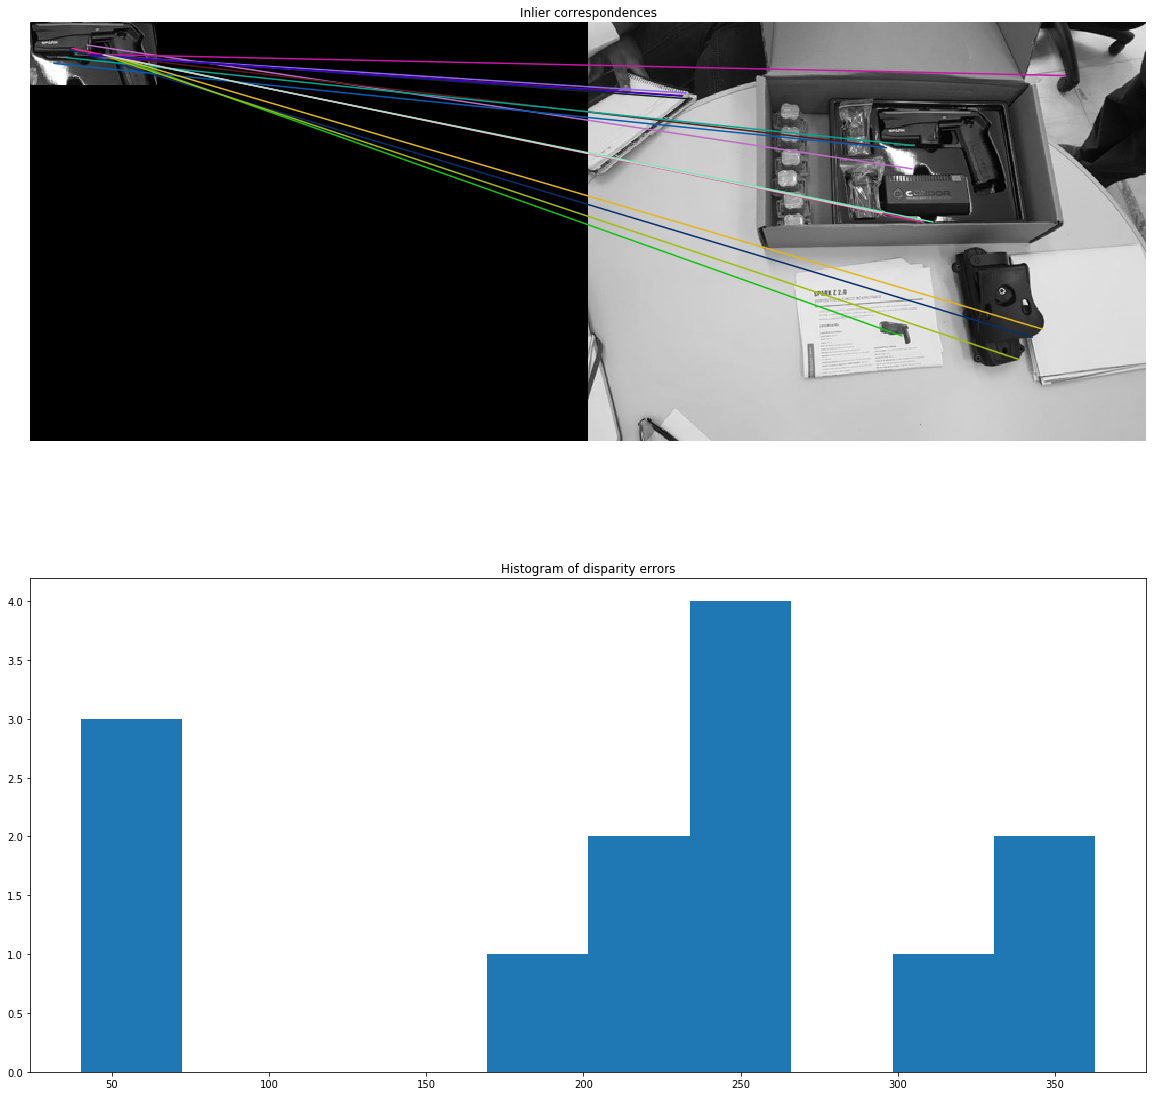

In [33]:
# Compare estimated sparse disparities to the dense ground-truth disparities.

disp = inlier_keypoints_left[:, 1] - inlier_keypoints_right[:, 1]
disp_coords = np.round(inlier_keypoints_left).astype(np.int64)
disp_idxs = np.ravel_multi_index(disp_coords.T, groundtruth_disp.shape)
disp_error = np.abs(groundtruth_disp.ravel()[disp_idxs] - disp)
disp_error = disp_error[np.isfinite(disp_error)]

# Visualize the results.

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))

plt.gray()

plot_matches(ax[0], img_left, img_right, keypoints_left, keypoints_right,
             matches[inliers], only_matches=True)
ax[0].axis("off")
ax[0].set_title("Inlier correspondences")

ax[1].hist(disp_error)
ax[1].set_title("Histogram of disparity errors")

plt.show()